In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
modelpath = '/eos/uscms/store/user/ekoenig/weaver/analysis/models/exp_sixb_diff_aggr/feynnet_ranker_6b/20230728_59b53a4bde5e7da6eb8e6aa522b30859_ranger_lr0.0047_batch2000_withbkg'

In [4]:
sigfile = '/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-1000_MY-250_TuneCP5_13TeV-madgraph-pythia8/ntuple.root'

In [16]:
fc.sixb = fc.FileCollection('/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_mmmm/')

In [17]:
f_qcd = fc.sixb.QCD_B_List

In [36]:
f_tt = list(map(lambda f : f.replace('ntuple_0','ntuple'), fc.sixb.TTJets))

In [37]:
bkg = ObjIter([
    Tree(f_qcd),
    Tree(f_tt),
])

100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


In [66]:
f_data = fc.sixb.JetHT_Data_UL.get('ntuple.root')
data = ObjIter([Tree(f_data)])

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


In [68]:
lumi = lumiMap[2018][0]

In [69]:
bkg.genWeight

[<Array [1, 1, 1, 1, ... 0.0455, 0.0455, 0.0909] type='2693 * float32'>, <Array [-5.52e+03, -5.52e+03, ... 5.52e+03] type='8485 * float32'>]

In [70]:
lumi*bkg.scale.cat

<Array [902, 902, 902, ... 4.08, -4.08, 4.08] type='11178 * float64'>

In [71]:
bkg.Run

[<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='2693 * uint32'>, <Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='8485 * uint32'>]

In [102]:
def n_loose_btag(t):
    return ak.sum(t.jet_btag > jet_btagWP[1], axis=1)

def n_medium_btag(t):
    return ak.sum(t.jet_btag > jet_btagWP[2], axis=1)

100%|██████████| 2/2 [00:00<00:00, 31.11it/s]


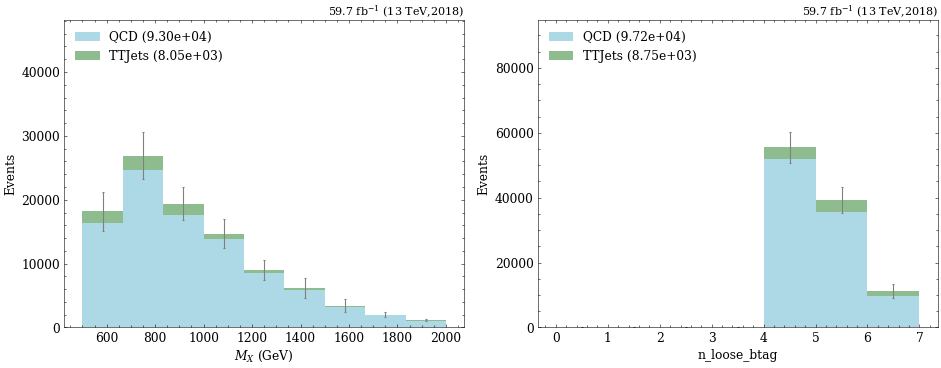

In [73]:
study.quick(
    bkg,
    varlist=['X_m', n_loose_btag, n_ed],
    h_rebin=10,
    legend=True,
    # efficiency=True,
)

In [74]:
from utils.rootUtils.TEfficiency import TEfficiency

fname = '/uscms_data/d3/ekoenig/8BAnalysis/analysis/CMSSW_10_6_28/src/MultiHiggs/analysis/MultiHAnalysis/data/btag/efficiency/sixb/eff_wp_deepJet_2018.root'

b_eff = TEfficiency.from_root(fname, 'eff/medium_hf5_jet_eta')
c_eff = TEfficiency.from_root(fname, 'eff/medium_hf4_jet_eta')
guds_eff = TEfficiency.from_root(fname, 'eff/medium_hf0_jet_eta')

In [75]:
from pandas import read_csv

sf_file = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/MultiHiggs/analysis/MultiHAnalysis/data/btag/2018/wp_deepJet_BTVPOG.csv'
sf_data = read_csv(sf_file)
medium_mask = sf_data['OperatingPoint'] == 'M'
central_mask = sf_data['sysType'] == 'central'
comb_mask = sf_data['measurementType'] == 'comb'
incl_mask = sf_data['measurementType'] == 'incl'
bFlav_mask = sf_data['jetFlavor'] == 5
cFlav_mask = sf_data['jetFlavor'] == 4
gudsFlav_mask = sf_data['jetFlavor'] == 0

b_mask = medium_mask & central_mask & comb_mask & bFlav_mask
c_mask = medium_mask & central_mask & comb_mask & cFlav_mask
guds_mask = medium_mask & central_mask & incl_mask & gudsFlav_mask

b_eqn = sf_data[b_mask]['formula'].iloc[0]
c_eqn = sf_data[c_mask]['formula'].iloc[0]
guds_eqn = sf_data[guds_mask]['formula'].iloc[0]

In [76]:
def get_btag_sf(tree):
    jet_btag = tree.jet_btag
    jet_pt = tree.jet_pt
    jet_eta = tree.jet_eta
    jet_hadronFlav = tree.jet_hadronFlav
    # jet_tagged = ak.argsort(ak.argsort(-jet_btag, axis=1)) < 4
    jet_tagged = jet_btag > jet_btagWP[2]

    # X = (jet_pt, jet_eta, )
    X = (jet_eta, )
    jet_b_eff = b_eff.GetEfficiency(*X)
    jet_c_eff = c_eff.GetEfficiency(*X)
    jet_guds_eff = guds_eff.GetEfficiency(*X)


    jet_eff = ak.where(
        jet_hadronFlav == 5, jet_b_eff,
    ak.where(
        jet_hadronFlav == 4, jet_c_eff, jet_guds_eff
    ))
    jet_guds_sf = eval(guds_eqn, dict(log=np.log, x=jet_pt))
    jet_c_sf = eval(c_eqn, dict(log=np.log, x=jet_pt))
    jet_b_sf = eval(b_eqn, dict(log=np.log, x=jet_pt))

    jet_sf = ak.where(
        jet_hadronFlav == 5, jet_b_sf,
    ak.where(
        jet_hadronFlav == 4, jet_c_sf, jet_guds_sf
    ))
    jet_prob_mc = ak.where(jet_tagged, jet_eff, 1-jet_eff)
    jet_prob_data = ak.where(jet_tagged, jet_eff*jet_sf, 1-jet_eff*jet_sf)

    prob_mc = ak.prod(jet_prob_mc, axis=1)
    prob_data = ak.prod(jet_prob_data, axis=1)

    weight = prob_data/prob_mc
    tree.extend(btag_sf=weight)

In [77]:
bkg.apply(get_btag_sf)

[None, None]

In [78]:
btagavg = 'ak.mean(jet_btag, axis=1)'

In [92]:
bkg.btag_sf.apply(np.mean)

[0.8702271078214672, 0.8841846345332117]

In [97]:
ak.max(bkg.btag_sf.cat)

3.2632296308233584

100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


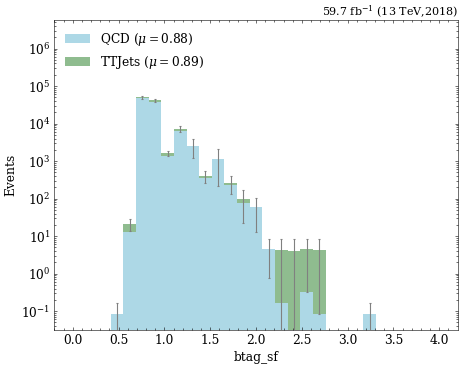

In [101]:
study.quick(
    bkg,
    varlist=['btag_sf'],
    binlist=[(0,4,30)],
    log=True,
    legend=True,
    h_label_stat='mean'
)

100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


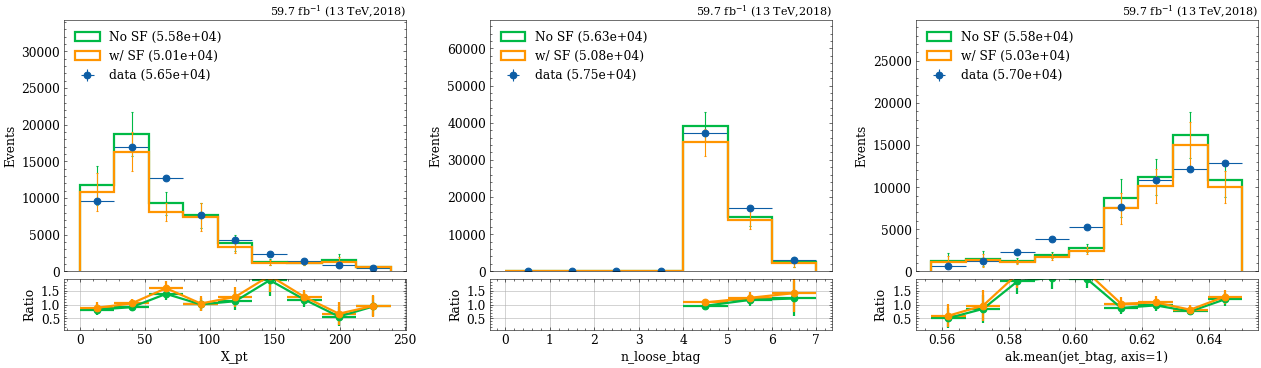

In [93]:
study.quick_region(
    data,bkg,bkg,
    masks=lambda t : t[btagavg] < 0.65,
    h_color=None,
    label=['data','No SF','w/ SF'],
    scale=[None]*len(bkg)+[lambda t : t.btag_sf]*len(bkg),
    h_rebin=10,
    varlist=['X_pt',n_loose_btag, btagavg],
    ratio=True,
    legend=True,
)